# BAIS 6040 Data Programming in Python

## Spring 2021

## Week 9, Homework 7

## Notebook 2 - Results of Machine Learning Analysis

## Group 3: Jared Barkley, Tyler Zaruba, Netaji Boggarapu, Michael Noonan

In [1]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score, mean_absolute_error, r2_score, mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

In [2]:
# Import project data

compiledcountydata_dir = "https://raw.githubusercontent.com/jaredbarkley0/PythonGroupProject/master/MN%20County%20Data_032721.csv"
compiledcountydata = pd.read_csv(compiledcountydata_dir)
compiledcountydata

,Unnamed: 0,County,Total Positive Cases,Total Deaths,Population,Rate of Infection,Death Rate,Pop Density,Mean Household Size,Congregate Living Population,No. of Cases in Nursing Homes,No. of Nursing Homes in County,"Nursing Home Cases, % of Total",Cases per number of Nursing Homes
0,0,Aitkin,1191,33,15870.0,0.075047,36.090909,8.0,2.097233,254.0,118.0,4.0,0.099076,29.500000
1,1,Anoka,33391,390,362648.0,0.092076,85.617949,753.9,2.712716,3753.0,1675.0,35.0,0.050163,47.857143
2,2,Becker,3131,42,34545.0,0.090635,74.547619,22.8,2.393929,477.0,294.0,8.0,0.093900,36.750000
3,3,Beltrami,3386,51,47184.0,0.071762,66.392157,14.8,2.487013,1990.0,264.0,11.0,0.077968,24.000000
4,4,Benton,4482,90,40895.0,0.109598,49.800000,94.4,2.426614,1050.0,557.0,11.0,0.124275,50.636364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,82,Watonwan,1176,8,10923.0,0.107663,147.000000,25.4,2.397507,151.0,36.0,3.0,0.030612,12.000000
83,83,Wilkin,677,11,6226.0,0.108738,61.545455,8.7,2.238850,152.0,36.0,2.0,0.053176,18.000000
84,84,Winona,4193,49,50830.0,0.082491,85.571429,79.9,2.352632,3855.0,277.0,9.0,0.066062,30.777778
85,85,Wright,12554,116,138531.0,0.090622,108.224138,178.3,2.796739,1158.0,687.0,20.0,0.054724,34.350000


In [3]:
# Check dataframe summary info

compiledcountydata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87 entries, 0 to 86
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         87 non-null     int64  
 1   County                             87 non-null     object 
 2   Total Positive Cases               87 non-null     int64  
 3   Total Deaths                       87 non-null     int64  
 4   Population                         87 non-null     float64
 5   Rate of Infection                  87 non-null     float64
 6   Death Rate                         87 non-null     float64
 7   Pop Density                        87 non-null     float64
 8   Mean Household Size                87 non-null     float64
 9   Congregate Living Population       87 non-null     float64
 10  No. of Cases in Nursing Homes      87 non-null     float64
 11  No. of Nursing Homes in County     87 non-null     float64
 

## Question 1 - What algorithm, of the ones attempted, appear to provide the best results, and why?

## Question 2 - What features ended up being the most interesting/meaningful for your test?

To begin analysis of the features of our data, we first created a correlation matrix in pandas an plotted it to a Seaborn heat map to give a quick visual of correlations within our data

<AxesSubplot:>

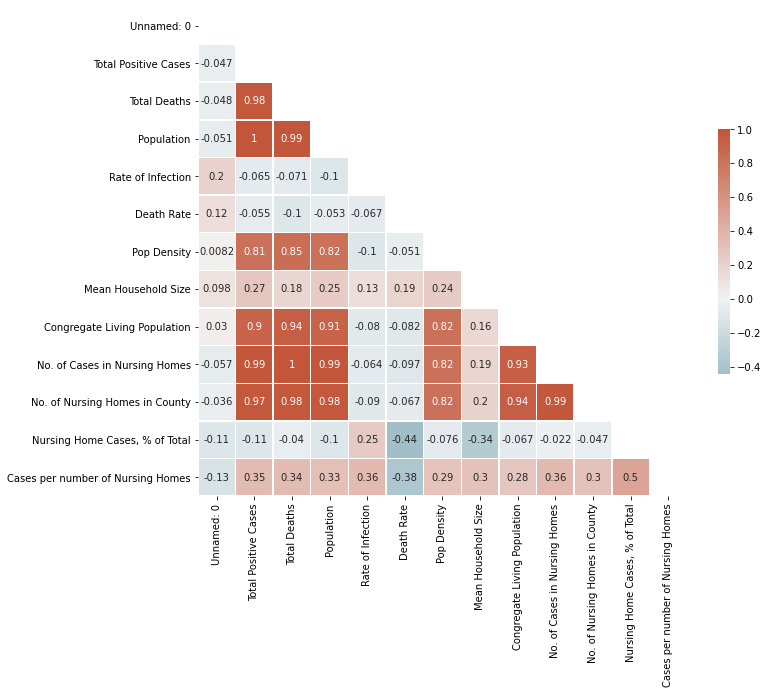

In [4]:
# Create a correlation matrix as a heat map

corr = compiledcountydata.corr()
f, ax = plt.subplots(figsize=(11, 9))
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, annot=True, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Analysis of the correlation matrix indicates we may have high multicollinearity between our variables.  Population, Total Positive Cases, Total Deaths and No. of Cases in Nursing Homes have an almost perfect relationship, suggesting that they are essentially measuring the same thing.  Categories which may be interesting to analyze are the Infection Rate, Death Rate, and total number of deaths.  Since Population, Total Deaths, Total Positive Cases and No. of Cases in Nursing Homes all have correlations greater than 98%. Feature analysis will include Total Deaths as a target of interest, but will not use the other highly correlated variables as explaining variables.

The initial question for our project was to see if we could identify any geospatial or community level characteristics that would correlate highly with increased spread of Covid or increased risk of death from covid.  To begin our analysis, we decided to investigate Rate of Infection, Total Deaths, and Death Rate as potential target variables.  Again, we wanted to avoid highly correlated variables that appeared to have extreme multicollinearity.  For consistency, we will evaluate each of our target variables of interest against the same explainer variables - Population density, Mean Household Size and Nursing Home Cases, % of Total.  These explainer variables were selected due to their ability to be roughly adjustable for counties of different size, although population density does still have a strong correlation with overall population.

First we performed a visual analysis graphing each of our explainer variables against each of our target variables, and also including a regression line in the plot for easy identification of potential linear relationships.

In [5]:
# Helper function to select a target variable and multiple feature variables
# then plot out scatterplots for visual analysis

def plotpairgrid(dataframe, columns, target):
    pairgrid = dataframe[target + columns]
    pairgridplot = sns.PairGrid(pairgrid, y_vars=target, x_vars=columns, height = 5)
    pairgridplot.map(sns.regplot, color="green")
    pairgridplot.map(sns.scatterplot)

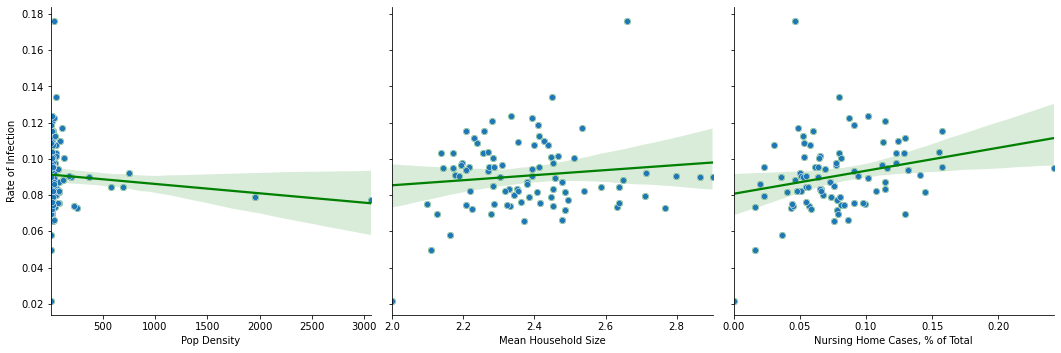

In [6]:
# Examine relationships between rate of infection and other aggregate variables

columns = ['Pop Density','Mean Household Size','Nursing Home Cases, % of Total']
rateofinfectiontarget = ['Rate of Infection']

plotpairgrid(compiledcountydata, columns, rateofinfectiontarget)

Rate of infection appears to be negatively impacted by pop density, and moderately positively impacted by the mean household size and nursing home case rate.

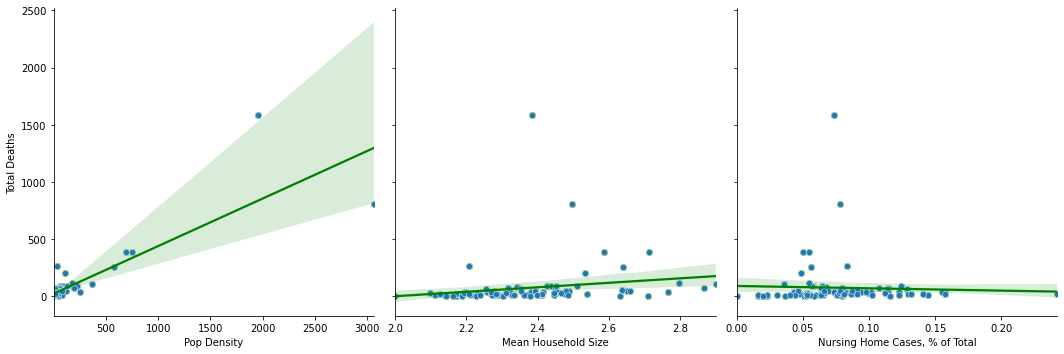

In [7]:
# Examine relationships between Total Deaths and population factors

totaldeathtarget = ['Total Deaths']

plotpairgrid(compiledcountydata, columns, totaldeathtarget)

Total Deaths appears to have the strongest relationship with Population Density.  Mean Household size appears to have a slightly positive impact, while nursing home case rate does not appear to have a significant relationship.

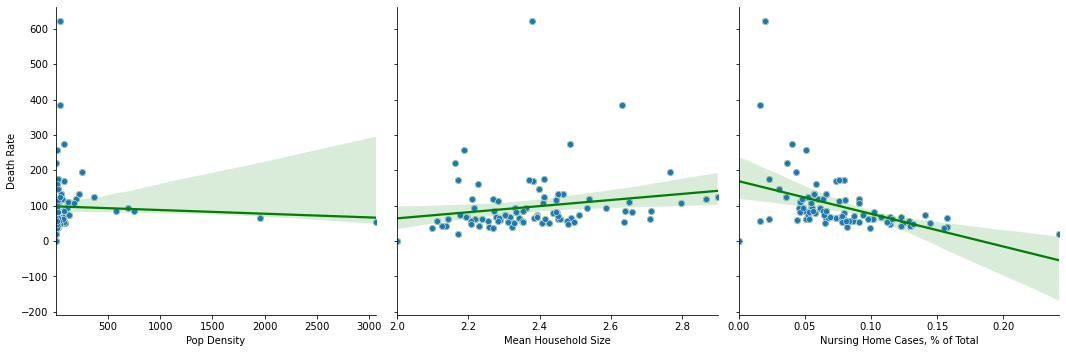

In [8]:
# Examine relationship between Death Rate and population factors

deathratetarget = ['Death Rate']

plotpairgrid(compiledcountydata, columns, deathratetarget)

Using visual analysis, we are able to see that there does appear to be at least a rough linear relationship between each of our target variables and at least one of the explainer variables, however it is difficult to understand how these relationships translate into a regression equation.  To analyze these variables effectiveness at explaining our target variables, we wrote a function which accepts the same input arguments as the linear plot functions, and outputs the summary regression statistics.

In [9]:
# Create function for linear regression that uses columns variable and different target variables defined above

def linreg(dataframe,columns,target):
    X = dataframe[columns]
    y = dataframe[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    print(f'My R-squared value is {lr.score(X_test, y_test)}')
    print(f'My slope coefficients are {lr.coef_}')
    print(f'My intercept is {lr.intercept_}')

In [10]:
# Examine regression quality for rate of infection

linreg(compiledcountydata, columns, rateofinfectiontarget)

My R-squared value is 0.21440303006192718
My slope coefficients are [[-6.78897936e-06  3.46622321e-02  1.27466396e-01]]
My intercept is [-0.0014577]


This model is not very effective at predicting rate of infection

In [11]:
# Examine regression quality for rate of infection

linreg(compiledcountydata,columns,totaldeathtarget)

My R-squared value is 0.770719263426767
My slope coefficients are [[  0.41746765 -26.75269407   5.93014824]]
My intercept is [91.93297608]


Overall model is better at predicting total number of deaths.  Pop Density correlates strongly with total population and total death

In [12]:
# Examine regression quality for death rate

linreg(compiledcountydata,columns,deathratetarget)

My R-squared value is 0.27066635243606196
My slope coefficients are [[-1.67500206e-02  2.01178472e+01 -7.97488182e+02]]
My intercept is [112.3255502]


This model is slightly better at predicting death rate than the infection rate, however it is still not a very good predictor overall.

## Feature Analysis Summary

Using this method on multiple combinations of columns allows us to quickly evaluate alternate sets of explainer variables and determine if they have a positive or negative impact on the quality of the prediction.  Alternative combinations which were explored included adding Number of Nursing Homes per County to the group of explainer variables.  This variable improved the quality of the regression output, but was removed due to high correlation with Total Deaths.  Number of Cases per Nursing Home was also included as another test.  This appeared to have promising linear relationship in visual analysis, but in regression analysis actually resulted in a lower quality model.